# EDA ACCIDENTES AERONAUTICOS

## Importamos librerias

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from summarytools import dfSummary
import matplotlib.pyplot as plt
import warnings

### Cargamos expedientes

In [7]:
expedientes = pd.read_csv(r"C:\Users\maxyf\OneDrive\Escritorio\CV\Proyecto accidentes aeronauticos\Archivos\expedientes_aeronauticos_limpio.csv")

### Outliers

Se realiza una busqueda de Outliers y se analiza la si es necesario eliminarlos

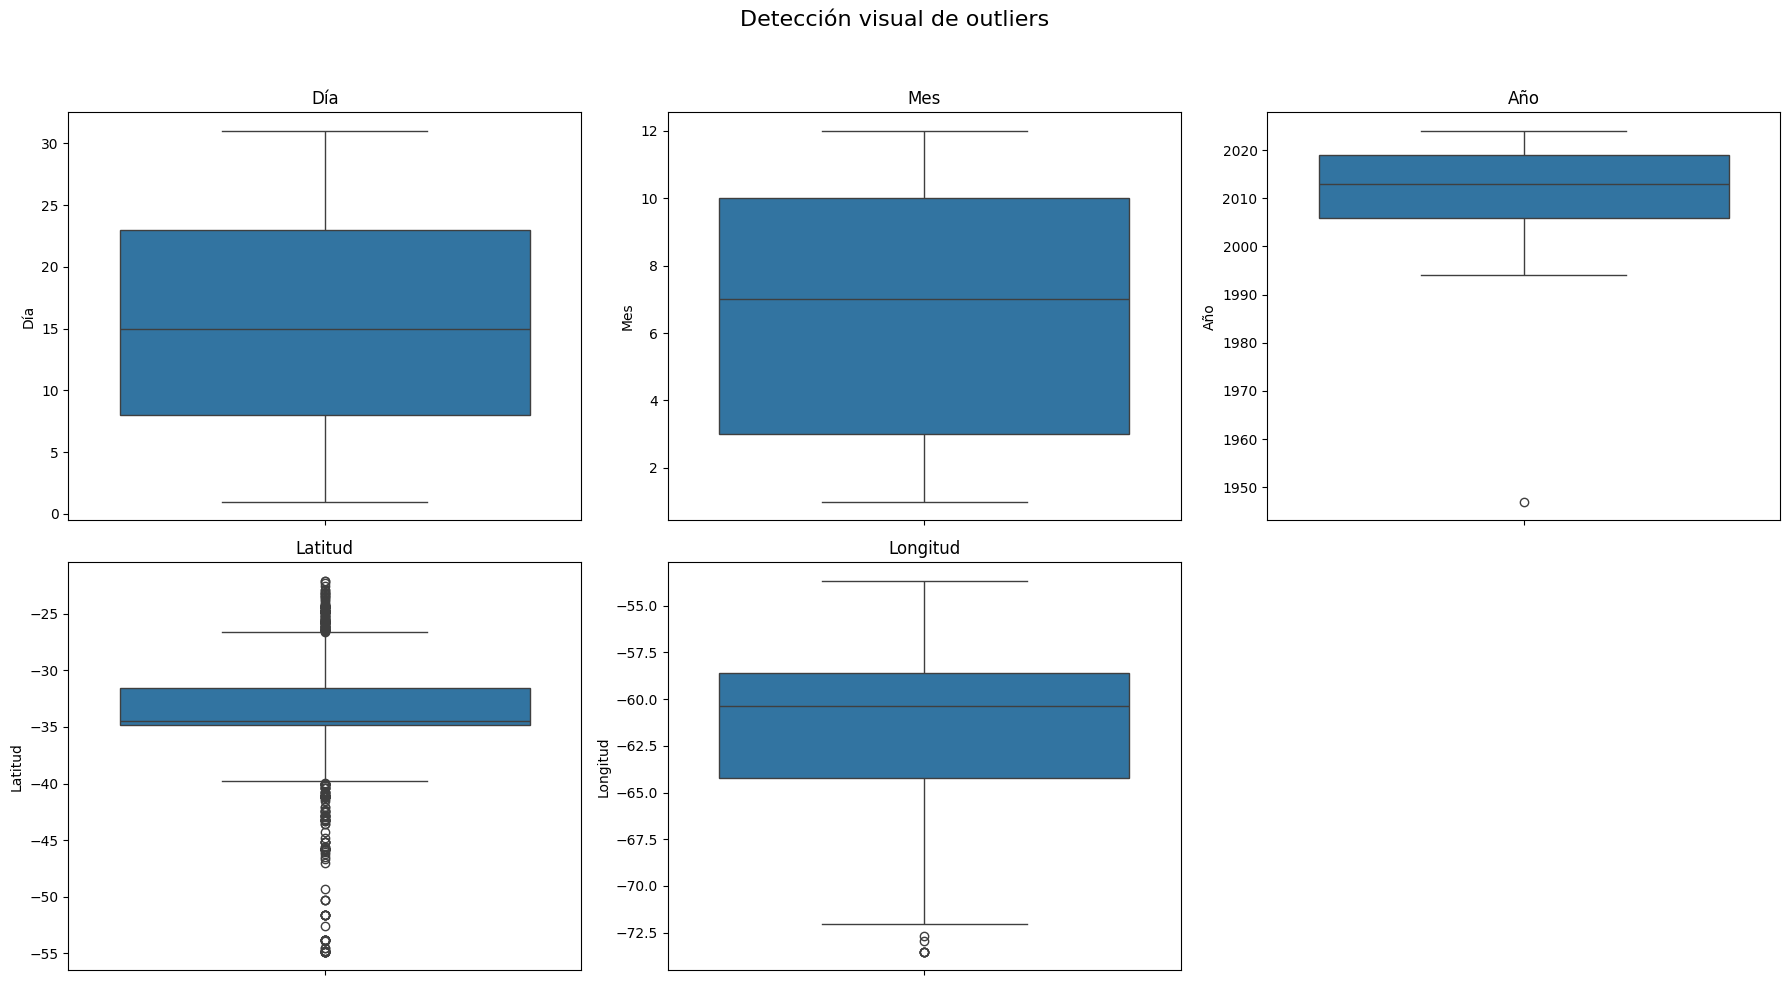

In [8]:
# Crear boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Detección visual de outliers', fontsize=16)

# Boxplot para Día
sns.boxplot(data=expedientes, y='Día', ax=axes[0, 0])
axes[0, 0].set_title('Día')

# Boxplot para Mes
sns.boxplot(data=expedientes, y='Mes', ax=axes[0, 1])
axes[0, 1].set_title('Mes')

# Boxplot para Año
sns.boxplot(data=expedientes, y='Año', ax=axes[0, 2])
axes[0, 2].set_title('Año')

# Boxplot para Latitud
sns.boxplot(data=expedientes, y='Latitud', ax=axes[1, 0])
axes[1, 0].set_title('Latitud')

# Boxplot para Longitud
sns.boxplot(data=expedientes, y='Longitud', ax=axes[1, 1])
axes[1, 1].set_title('Longitud')

# Ocultar el último subplot vacío
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Dejamos los datos Outliers ya que las coordenadas en ese ranfo pueden representar ubicaciones en Argentina


### Variables numéricas


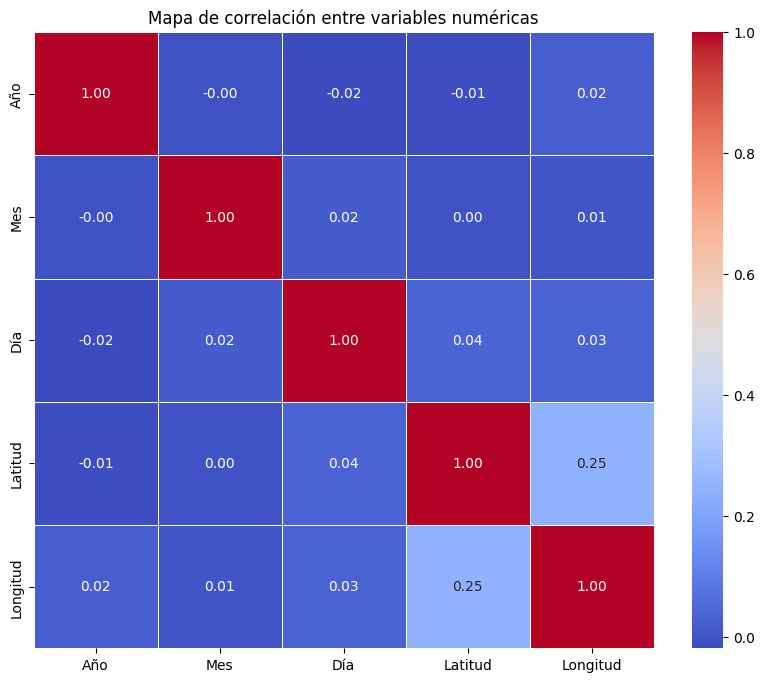

In [13]:
# Seleccionamos solo las columnas numéricas
numericas = expedientes.select_dtypes(include=["float64", "int64"])

# Calculamos la matriz de correlación
correlacion = numericas.corr()

# Creamos el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de correlación entre variables numéricas")
plt.show()

Podemos ver que no hay alguna correlacion fuerte entre las variantes


### Análisis Temporal – Accidentes por Año

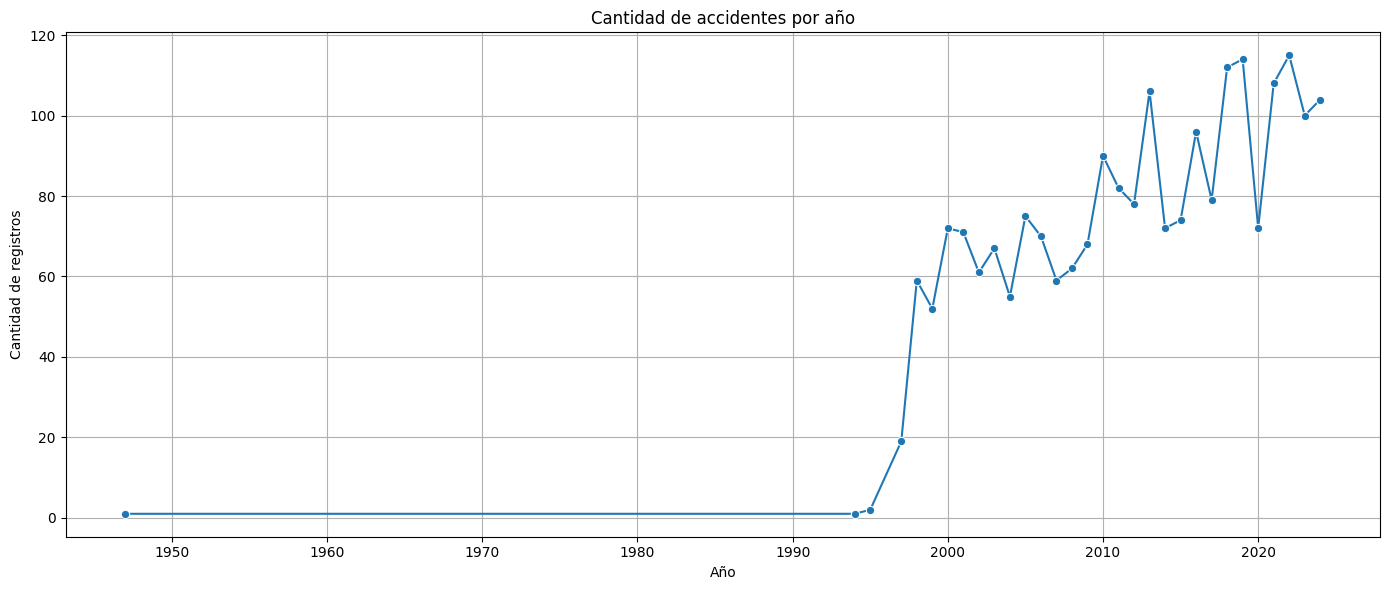

In [15]:
# Agrupar por año (asegurarse de que sea numérico)
expedientes['Año'] = pd.to_numeric(expedientes['Año'], errors='coerce')
accidentes_por_anio = expedientes['Año'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(14, 6))
sns.lineplot(x=accidentes_por_anio.index, y=accidentes_por_anio.values, marker='o')
plt.title('Cantidad de accidentes por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de registros')
plt.grid(True)
plt.tight_layout()
plt.show()

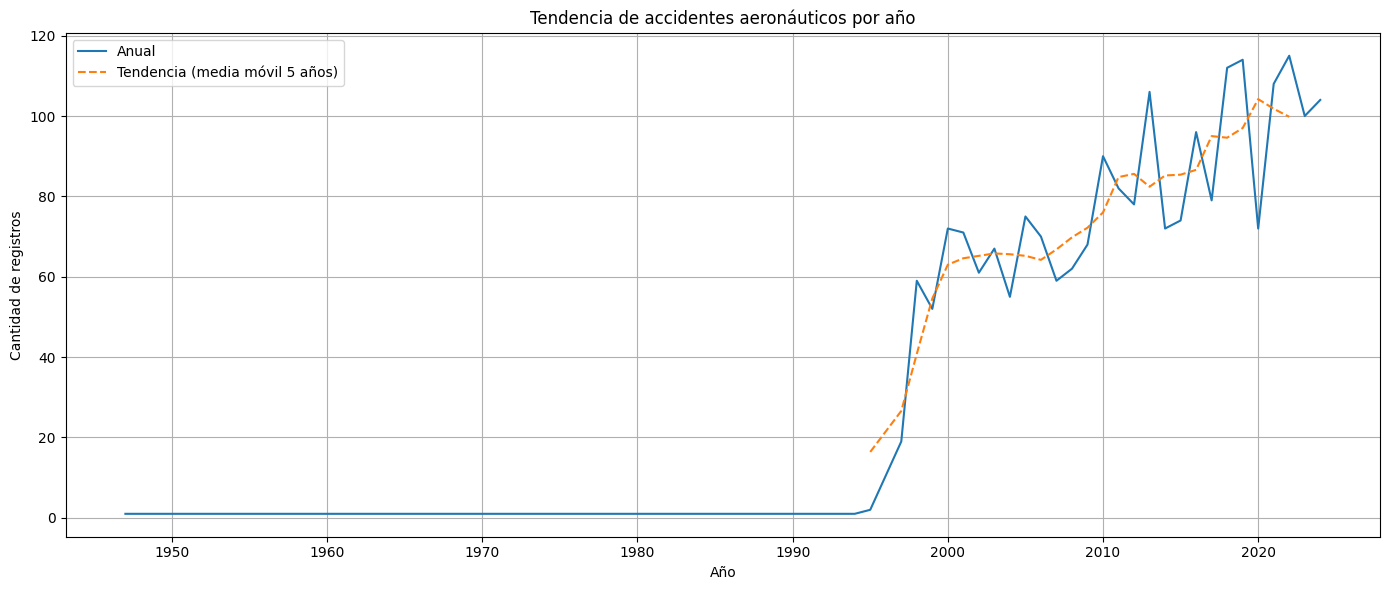

In [16]:
# Media móvil
expedientes_anio_rolling = accidentes_por_anio.rolling(window=5, center=True).mean()

# Graficar con tendencia
plt.figure(figsize=(14, 6))
sns.lineplot(x=accidentes_por_anio.index, y=accidentes_por_anio.values, label='Anual')
sns.lineplot(x=expedientes_anio_rolling.index, y=expedientes_anio_rolling.values, label='Tendencia (media móvil 5 años)', linestyle='--')
plt.title('Tendencia de accidentes aeronáuticos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de registros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()